In [4]:
from settings import *
import numpy as np
from keras.utils import to_categorical
import utils as ut
import warnings
from Bio import Phylo
from Bio.Phylo.BaseTree import Tree
from matplotlib import pyplot as plt
import TreeClass
from TreeClass import Phylogenetic_Tree
import copy
import random
from data_generator import simulate_artificial_data
import MCMC 

seed = 3
np.random.seed(seed)
random.seed(seed)

## Generate artificial data

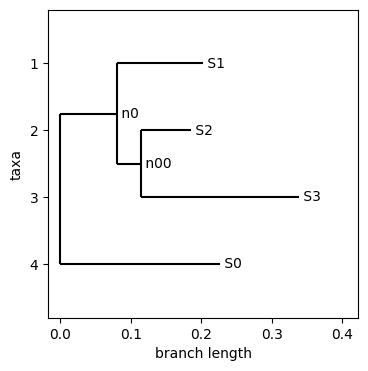

In [5]:
# Generate artificial data

seq_len = 100
n_taxa = 4
outgroup = "S0" # Outgroup fixed

exponential_params = {"distribution": "exponential", "scale": 0.1} 

true_tree, data = simulate_artificial_data(n_taxa, seq_len, outgroup, exponential_params)
taxa_names = list(data.keys())
taxa_sequences = list(data.values())

# Draw true tree
true_tree.draw()

## Perform MCMC sampling using NNI searcher

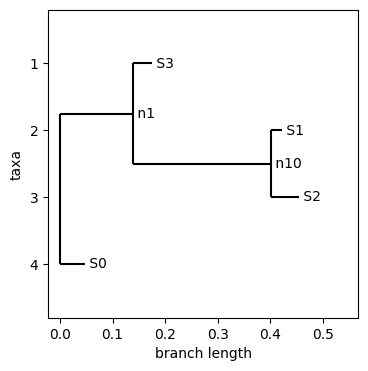

In [6]:
tree_init = MCMC.initialize_random_tree(taxa_names, taxa_sequences, outgroup, exponential_params)
tree_init.draw()

True tree:


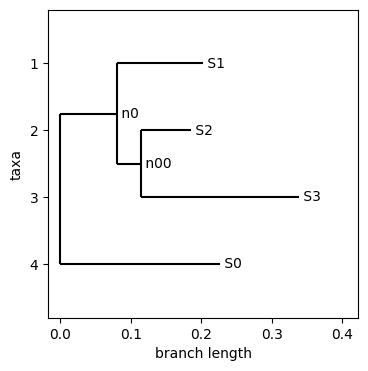

Initial proposal:


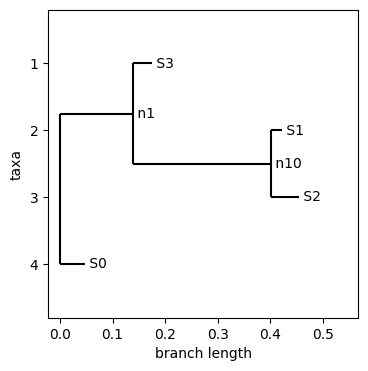

0
Final tree:


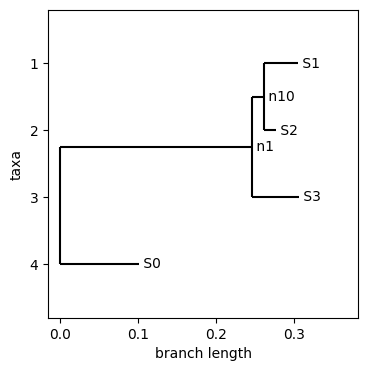

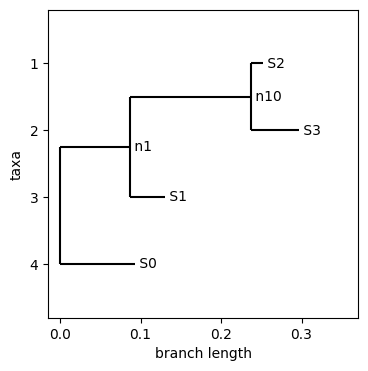

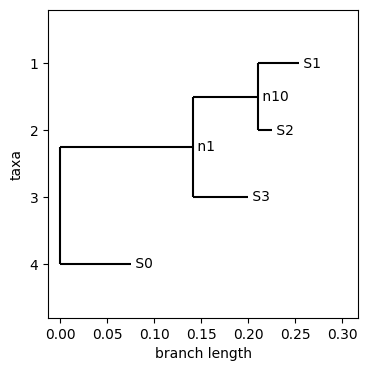

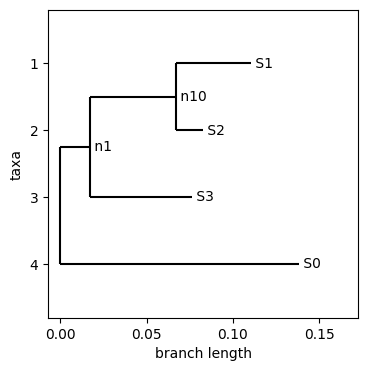

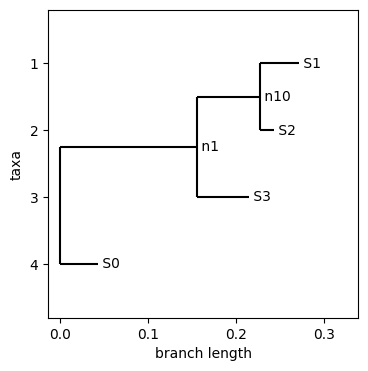

In [7]:
# # NNI step:
# choose a node (from the eligible nodes)
# create new topology by performing NNI
# propose branch lengths
# compute likelihood

def NNI_step(tree_init, distribution_params):
    NNI_nodes = tree_init.NNI_eligible_nodes()
    chosen_node = random.choice(NNI_nodes)
    permutable = tree_init.NNI_permutable_nodes(chosen_node)
    _, tree_init.loglikelihood = tree_init.calculate_likelihood(log=True)

    for i in range(2):
        new_nodes = permutable[-(i+1):] + permutable[:-(i+1)]
        NNI_tree = tree_init.NNI_generate_topology(chosen_node, new_nodes)
        NNI_tree.generate_random_branch_lengths(distribution_params=distribution_params)
        _, NNI_tree.loglikelihood = NNI_tree.calculate_likelihood(log=True)

        delta_log_likelihood = NNI_tree.loglikelihood - tree_init.loglikelihood
        if distribution_params["distribution"] == "exponential": # TODO EXCLUDE outgroup branch length 
            tree_init.L = tree_init.calculate_total_tree_length() # total tree length initial tree
            NNI_tree.L = NNI_tree.calculate_total_tree_length() # total tree length proposal tree
            delta_log_likelihood -= (NNI_tree.L - tree_init.L) / distribution_params["scale"] # lambda of exponential distirbution, interval of uniform distribution
        elif distribution_params["distribution"] == "uniform":
            continue
        rho = np.min([1, np.exp(delta_log_likelihood)])

        if np.random.random() < rho:
            NNI_tree.accepted = True
            return NNI_tree
    
    tree_init.accepted = False
    return tree_init

print("True tree:")
true_tree.draw()

print("Initial proposal:")
tree_init.draw()

class Sampler():
    def __init__(self, taxa_names, taxa_sequences, outgroup, nwalkers=1):
        self.initial_tree_list = [MCMC.initialize_random_tree(taxa_names, taxa_sequences, outgroup) for i in range(nwalkers)]
        self.nwalkers = nwalkers

    # def lnprior(theta): # Prior definition 
    #     a1, a2, a3, p1, p2, p3, T0 = theta
    #     if #apply conditions on priors here
    #         return 0.0
    #     else:
    #         return -np.inf
        
    # def set_prior(self, )

    def run_mcmc(self, nsteps=1000, burn_in=100, save_frequency=100, branch_length_prior="exponential"): # save = True
        self.nsteps = nsteps
        self.burn_in = burn_in
        self.save_frequency = save_frequency
        self.branch_length_prior = branch_length_prior

        saved_trees = []
        self.accept_ratio = []
        
        for tree_init in self.initial_tree_list:
            saved_trees_per_walker = []
            accept = 0
            tree_init_copy = copy.deepcopy(tree_init)
            for n in range(self.nsteps):
                tree_init_copy = NNI_step(tree_init_copy, distribution=self.branch_length_prior)
                if tree_init_copy.accepted: accept +=1
                if n > self.burn_in and n % self.save_frequency == 0:
                    saved_trees_per_walker.append(tree_init_copy)
            saved_trees.append(saved_trees_per_walker)
            self.accept_ratio.append(accept / self.nsteps)

# MCMC walkers to be defined

saved_trees = []

nsteps = 1000
burn_in = 500
accept = 0
for i in range(nsteps):
    tree_init = NNI_step(tree_init, distribution_params=exponential_params)
    if i > burn_in and i % 100 == 0:
        saved_trees.append(tree_init)

print(accept)

Phylo.write(saved_trees, "Trees/saved_trees.nex", "nexus")

print("Final tree:")
tree_init.draw()

for tree in saved_trees:
    tree.draw()

# TODO: exclude outgroup branch length when calculating total tree branch length

In [ ]:
# Perform an iteration of a NNI chain

In [ ]:
# file_path = "Trees\\"
# file_name = "primates_and_galeopterus_cytb.nex"
# Phylo.convert(file_path+file_name, "nexus", file_path+"primates_and_galeopterus_cytb.dnd", "newick")
# # nexus_tree = Phylo.read(file_path + file_name, "nexus")
# # print(nexus_tree)

In [ ]:
# MAP_tree = Phylo.read("analyses\\primates_cytb_JC_MAP.tree", "nexus")

# for clade in MAP_tree.find_clades():
#     if type(clade.branch_length) == str:
#         bl = float(clade.branch_length[:8])
#         clade.branch_length = bl

# print(MAP_tree)
# # terminal_branch_lengths = np.array([clade.branch_length for clade in MAP_tree.get_terminals()])
# # internal_branch_lengths = np.array([clade.branch_length for clade in MAP_tree.get_nonterminals()])


# # bins = np.linspace(0, 0.3, 30)
# # plt.hist(terminal_branch_lengths, bins, alpha=0.5, label='terminal')
# # plt.hist(internal_branch_lengths, bins, alpha=0.5, label='internal')
# # plt.legend(loc='upper right')
# # plt.show()


# Phylo.draw(MAP_tree)

# MAP_tree.rooted = True
# # for clade in MAP_tree.find_clades():
# #     print(clade.clades)

# outgroup = ["Galeopterus_variegatus"]#, 0.050508999999999964]

# # Root the tree using the specified outgroup
# MAP_tree.root_with_outgroup(outgroup)
# # MAP_tree.root_at_midpoint()
# Phylo.draw(MAP_tree)

In [ ]:
# # Draw multiple overlapping trees TODO

# fig, ax = plt.subplots(figsize=(6,6))
# Phylo.draw(true_tree, axes=ax, do_show=False)
# Phylo.draw(tree_init, axes=ax)
# plt.show()

In [ ]:
taxa_names = ["Saimiri_sciureus", "Callicebus_donacophilus", "Cebus_albifrons", "Aotus_trivirgatus", "Hylobates_lar", "Pan_paniscus"]

tree_random = Phylogenetic_Tree().generate_random_topology(taxa_names=taxa_names)
# tree_random.generate_random_branch_lengths(distribution="uniform", type="ultrametric")
tree_random.draw(figsize=(10,6))

In [ ]:
# # Changes to insert in commit:
